# Cluster analysis

This notebook serves to visualize clusters extracted from the sales data.
Clustering can be done by any of the following methods:
* Dimentionality reduction followed by clustering using HDBCAN
* Self-Organizing Maps
* Dynamic Time Wapring Distance calculation followed by agglomerative clustering

Each of these techniques can have their clusters analysed in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import umap
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from VisualizationFunctions import plot_by_factor, AnalyzeClusters
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from dynamic_time_warping import Preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

Read in the data: labels, tsfresh features, product level aggregate time series, pivot table.

Scale the data.

In [2]:
agg = pd.read_csv('sku_labels.csv')
df = pd.read_csv('extracted_features.csv')
product_sales = pd.read_csv('aggregate_products.csv')
pivot_table = pd.read_csv('pivot_products.csv')
df.dropna(axis=1, inplace=True)

scale = StandardScaler()
skus = df['id']
df.set_index('id', inplace=True)
X = scale.fit_transform(df)
names = df.columns

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Dimentionality reduction
---
This dimentionality reduction is first of all for visualization of clusters, and also to see if any other groupings emerge from the dataset

In [53]:
print('Running UMAP Dimentionality Reduction...')
um = umap.UMAP(n_neighbors=3, min_dist=0.01)
umaps = um.fit_transform(X)

Running UMAP Dimentionality Reduction...


C:\ProgramData\Anaconda3\lib\site-packages\umap_learn-0.3.6-py3.6.egg\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)


In [54]:
#Merge umap coordinates onto original df with sku_keys
plot_df = pd.DataFrame(umaps).join(df.reset_index())

#Merge above umap and features table to sku_key and categories
plot_df['sku_key'] = plot_df['id'].astype(int)
agg['sku_key'] = agg['sku_key'].astype(int)
plot_df = plot_df.merge(agg, how='left', on='sku_key')

colors=['b', 'r', 'g', 'y', 'm', 'orange', 'gold', 'skyblue',
        'blue', 'red', 'green', 'yellow', 'brown', 'violet',
        'orchid', 'olive', 'black', 'grey', 'purple',
        'lime', 'darkblue', 'darkred', 'darkgreen',
        'tomato', 'lightgreen', 'lightblue', 'darkorange']

Visualize the distribution of departments along lower dimentional embedding

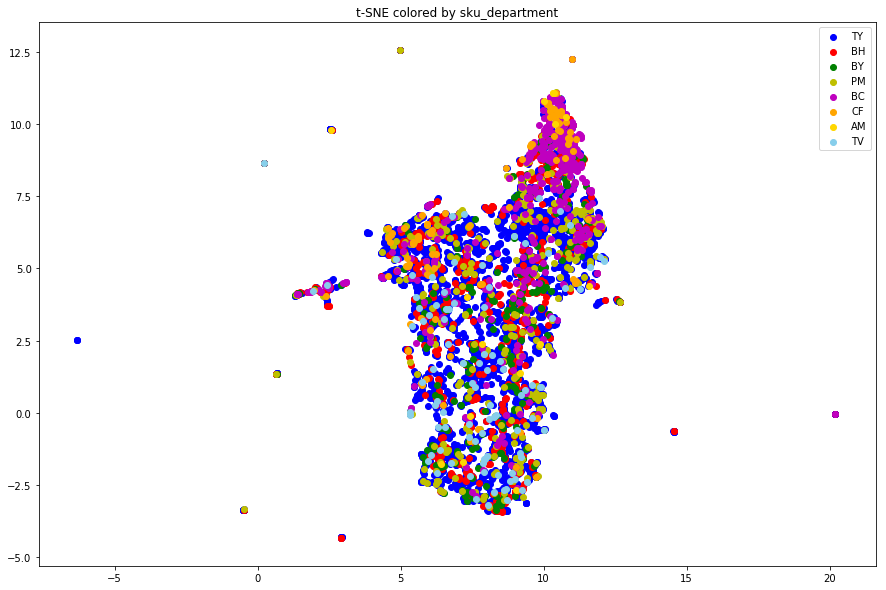

In [55]:
plot_by_factor(plot_df, 'sku_department', colors, showplot=True)

Show distribution of cumulative sales on embedding

In [56]:
sales_df = product_sales.groupby('sku_key').sum().reset_index()[['sku_key', 'sales']]\
.merge(plot_df, on='sku_key')[['sku_key', 'sales', 0,1]]
sales_df['sales_log'] = np.log10(sales_df['sales'])

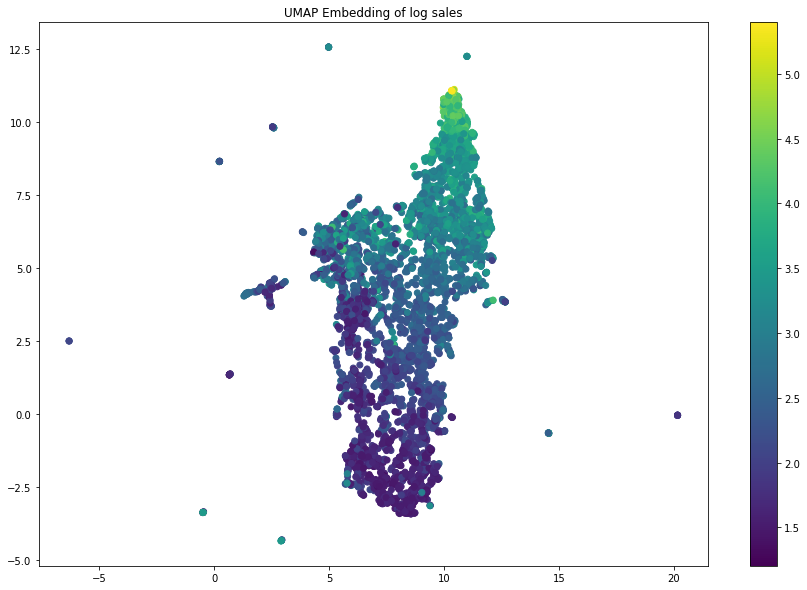

In [57]:
f, ax = plt.subplots(figsize=(15,10))
sc = ax.scatter(sales_df[0], sales_df[1], c=sales_df['sales_log'], cmap='viridis')
plt.colorbar(sc)
ax.set_title('UMAP Embedding of log sales')
plt.show()

# Clustering and cluster analysis

In [58]:
run_cont = ['sales', 'selling_price', 'avg_discount']
run_cats = ['sku_department', 'sku_subdepartment', 'sku_category', 'sku_subcategory']

In [59]:
som_clus = pd.read_csv('som_clusters.csv')
som_clus.columns = ['sku_key', 'cluster']

analyze_som = AnalyzeClusters()
df_dict = analyze_som.make_dataset(product_sales, som_clus)

Cluster sizes:


In [60]:
for i, j in df_dict.items():
    print(i, len(j))

cluster_5 1293758
cluster_1 1463628
cluster_2 376188
cluster_0 127446
cluster_4 13340
cluster_3 3975


Clusters on embedding

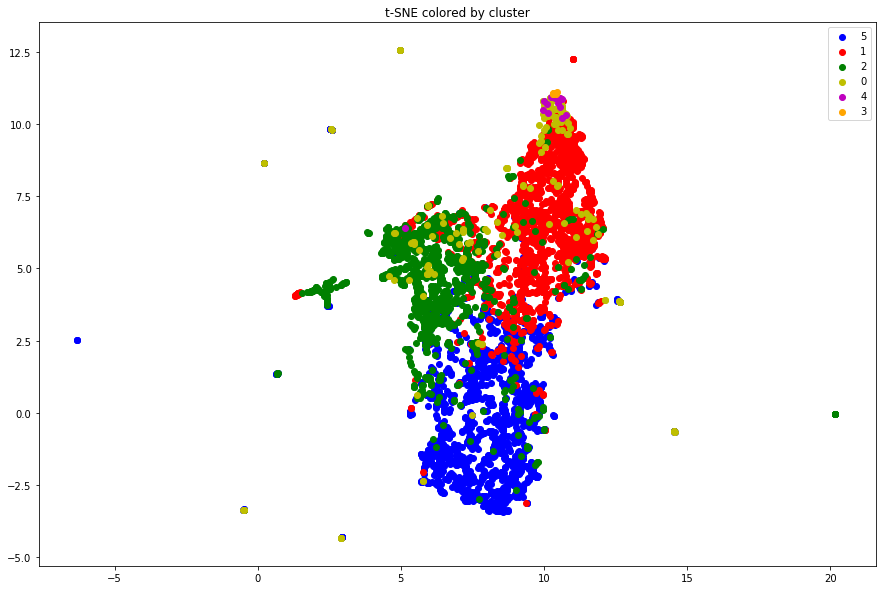

In [61]:
som_tsne = plot_df.merge(som_clus, left_on='id', right_on='sku_key')

plot_by_factor(som_tsne, 'cluster', colors, False)

Have a look at the time series for each of the clusters

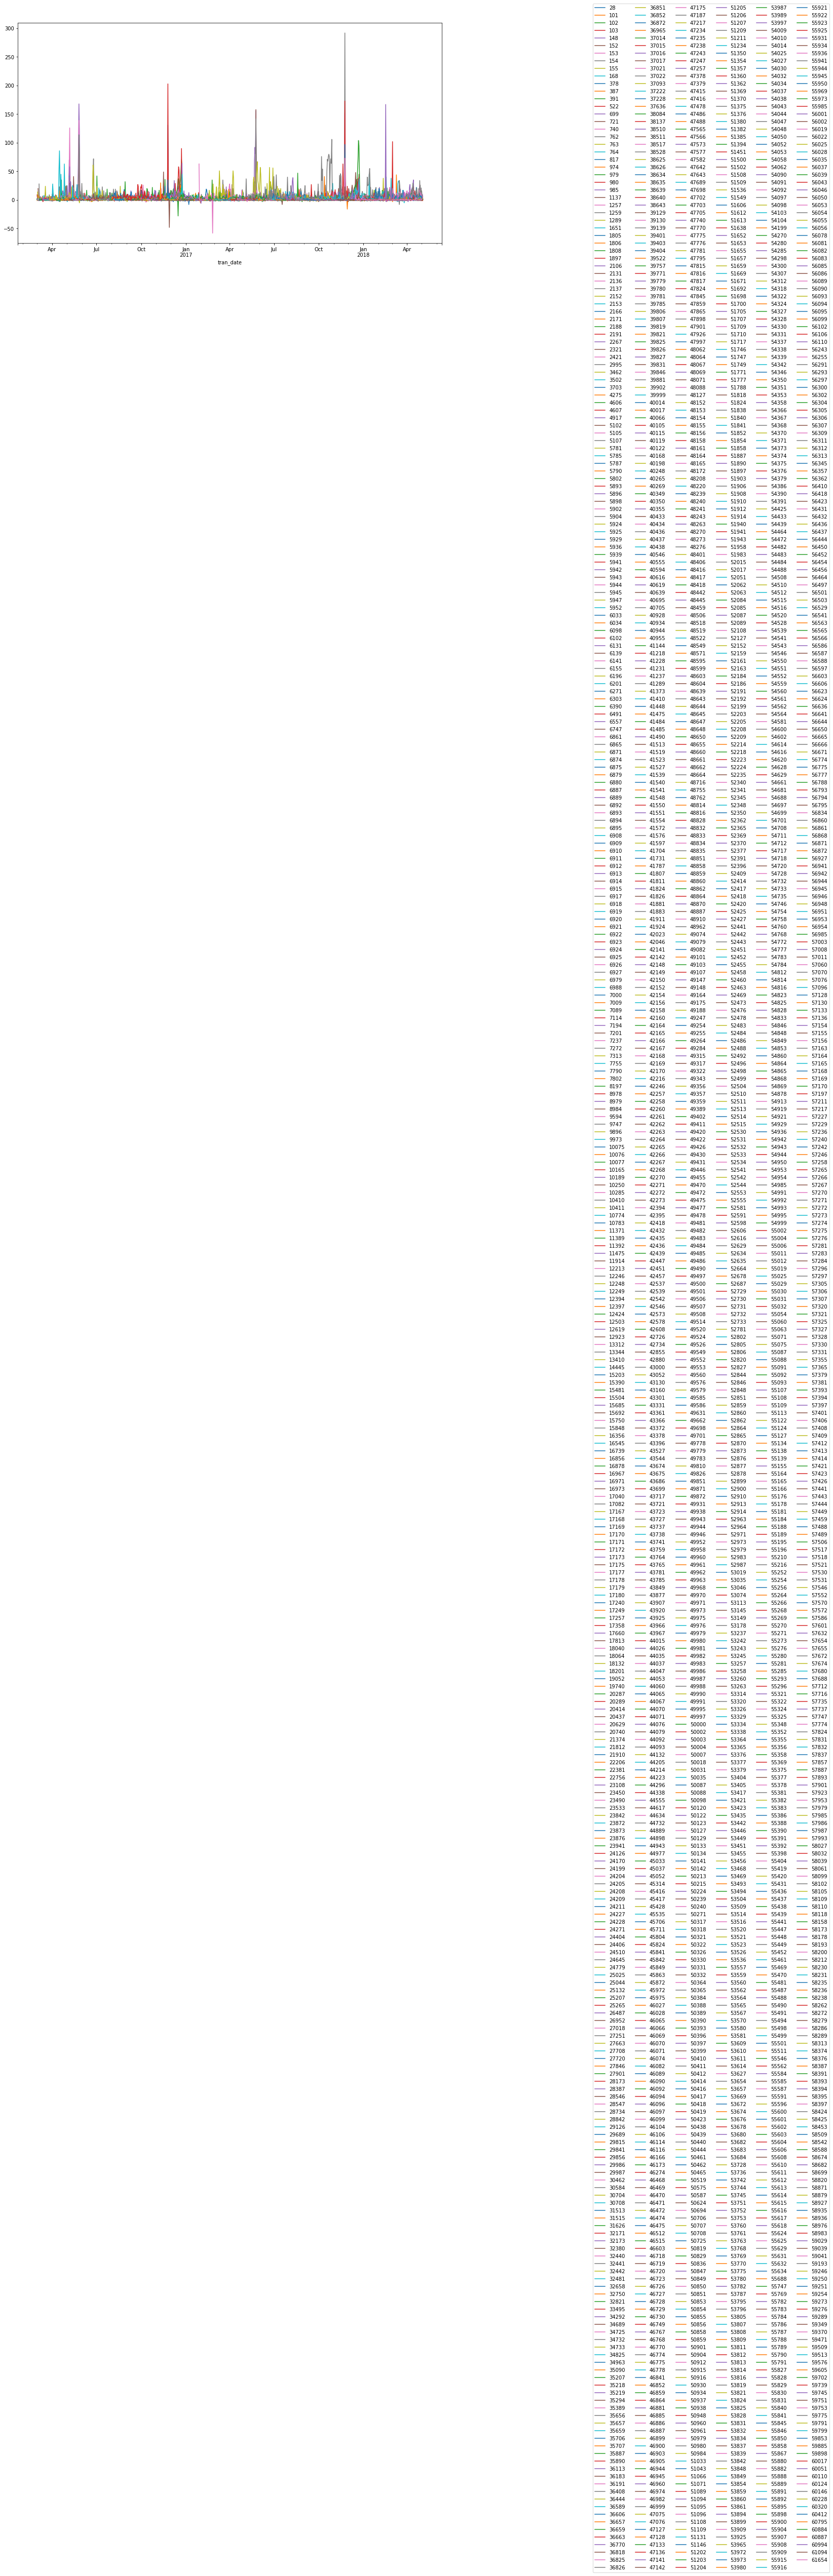

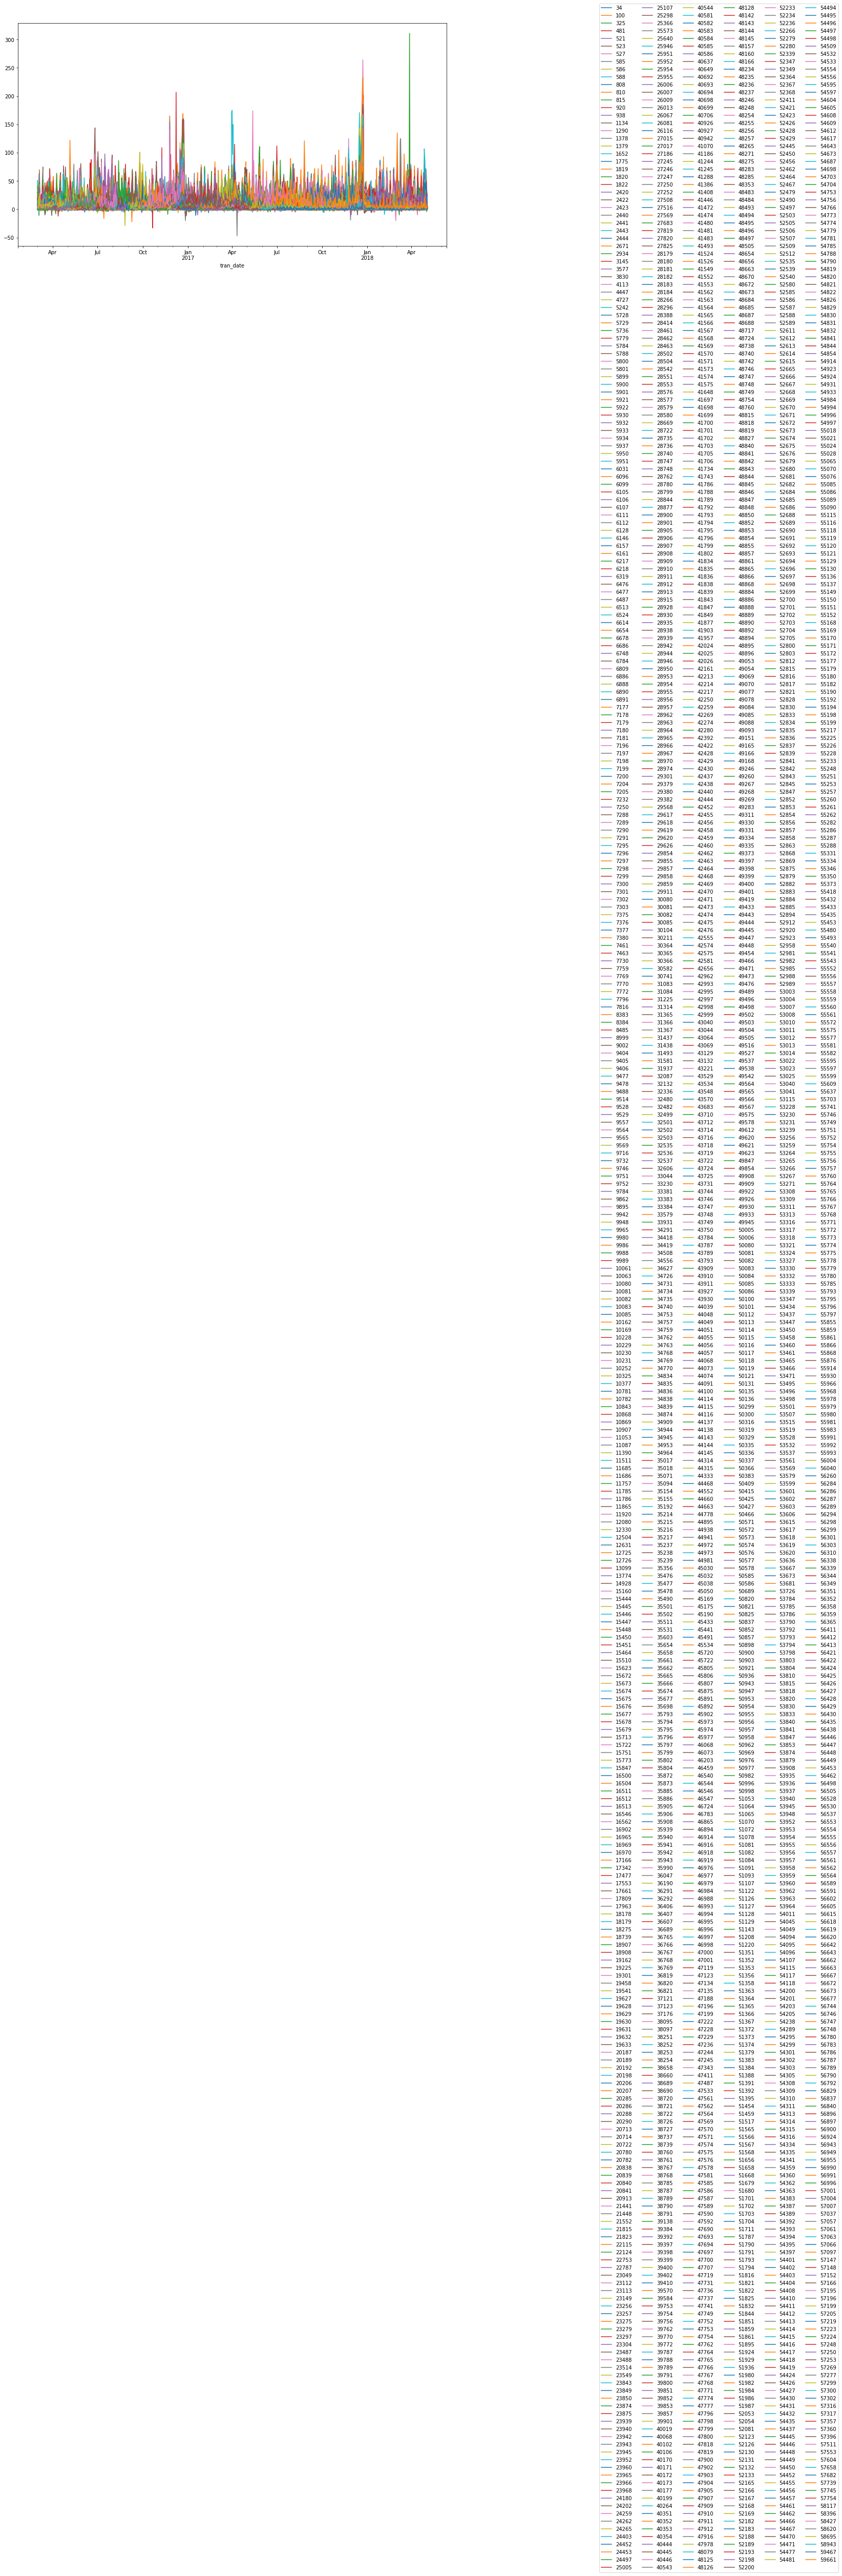

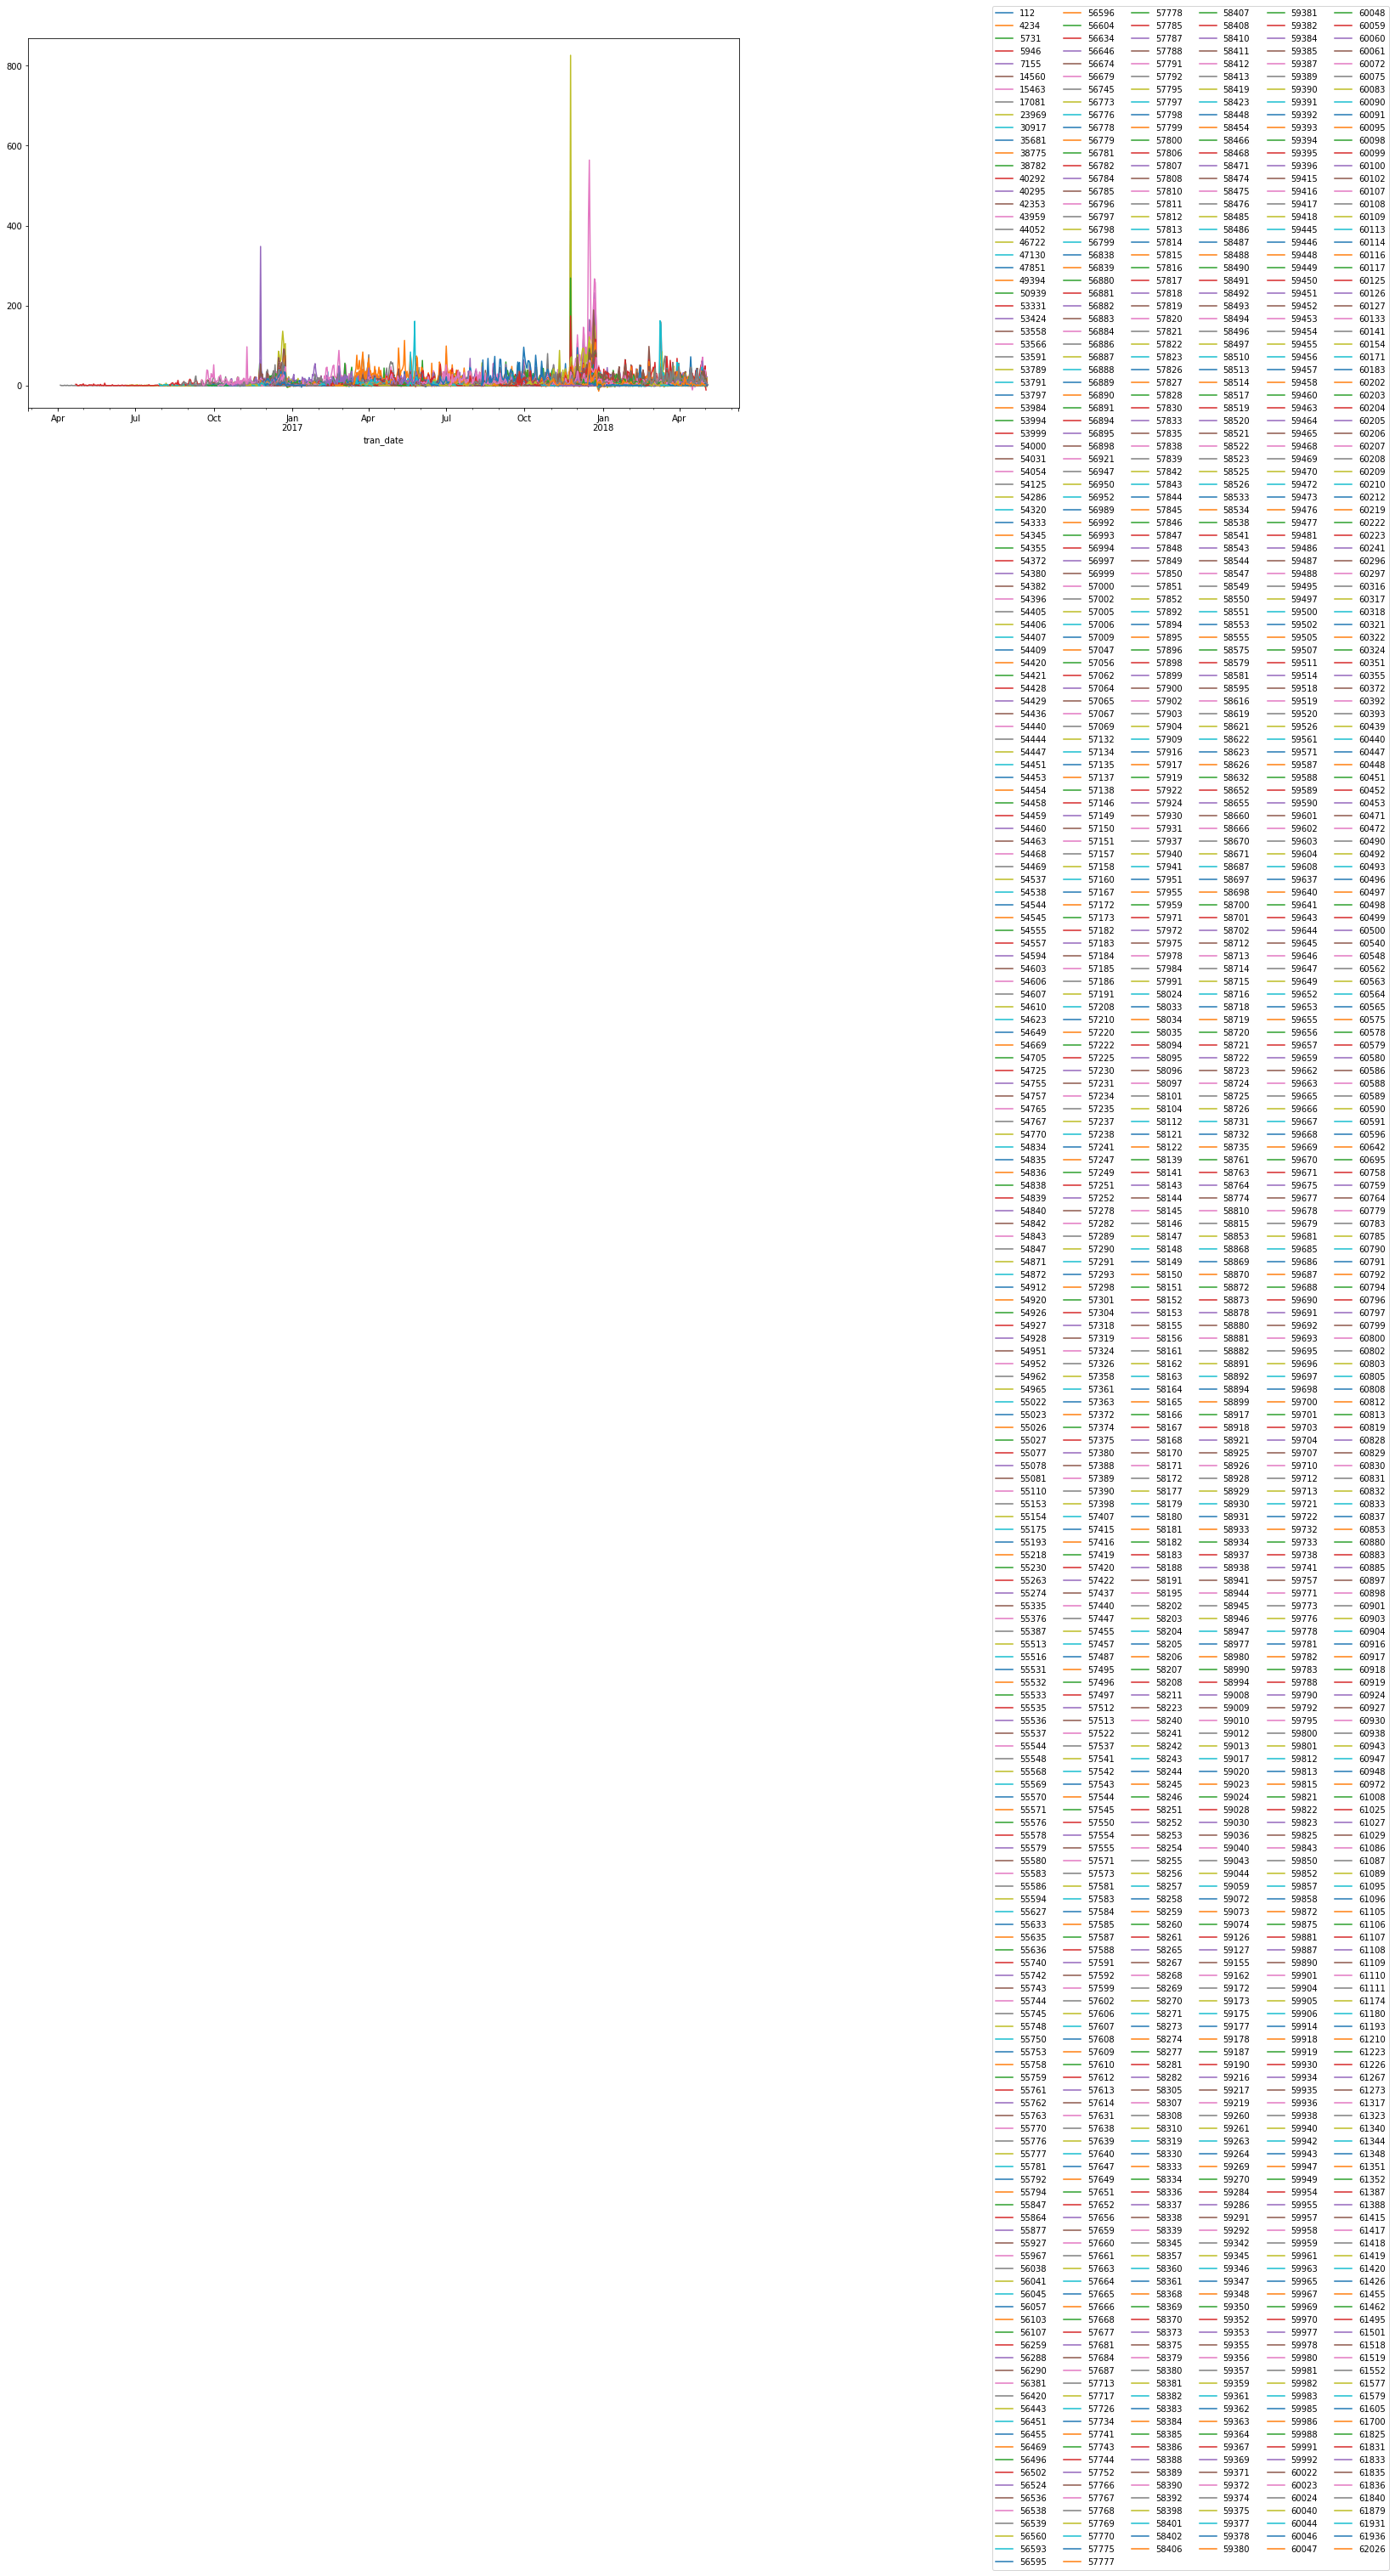

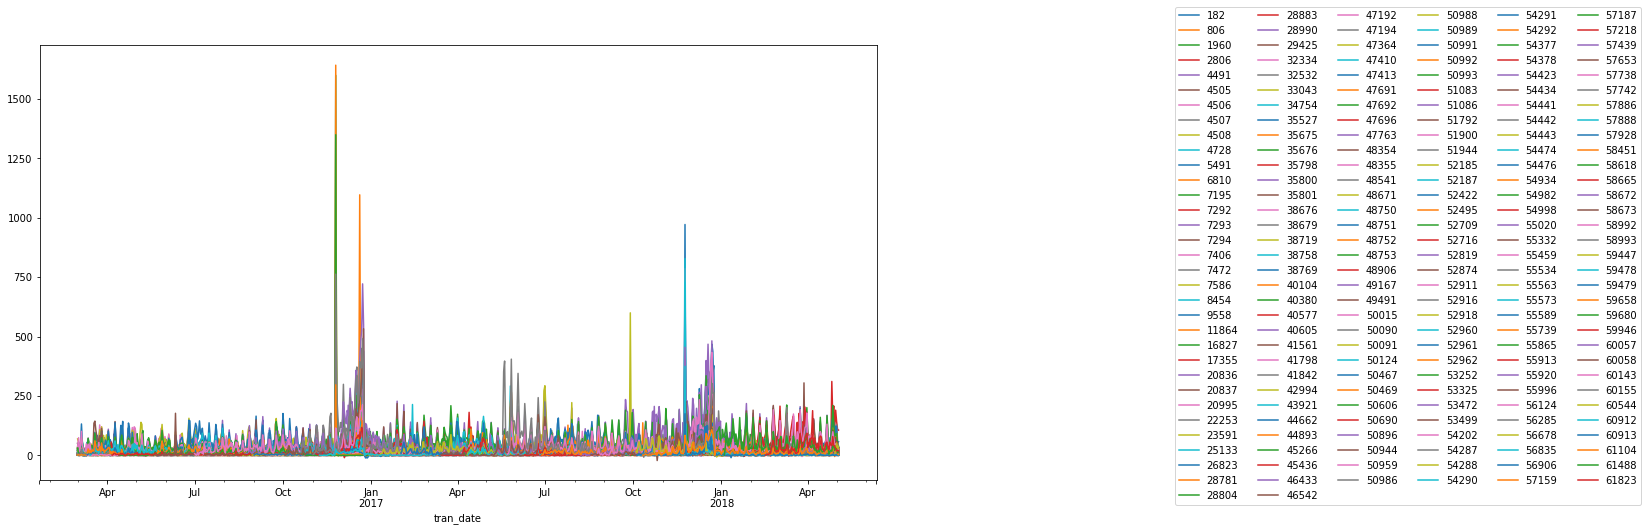

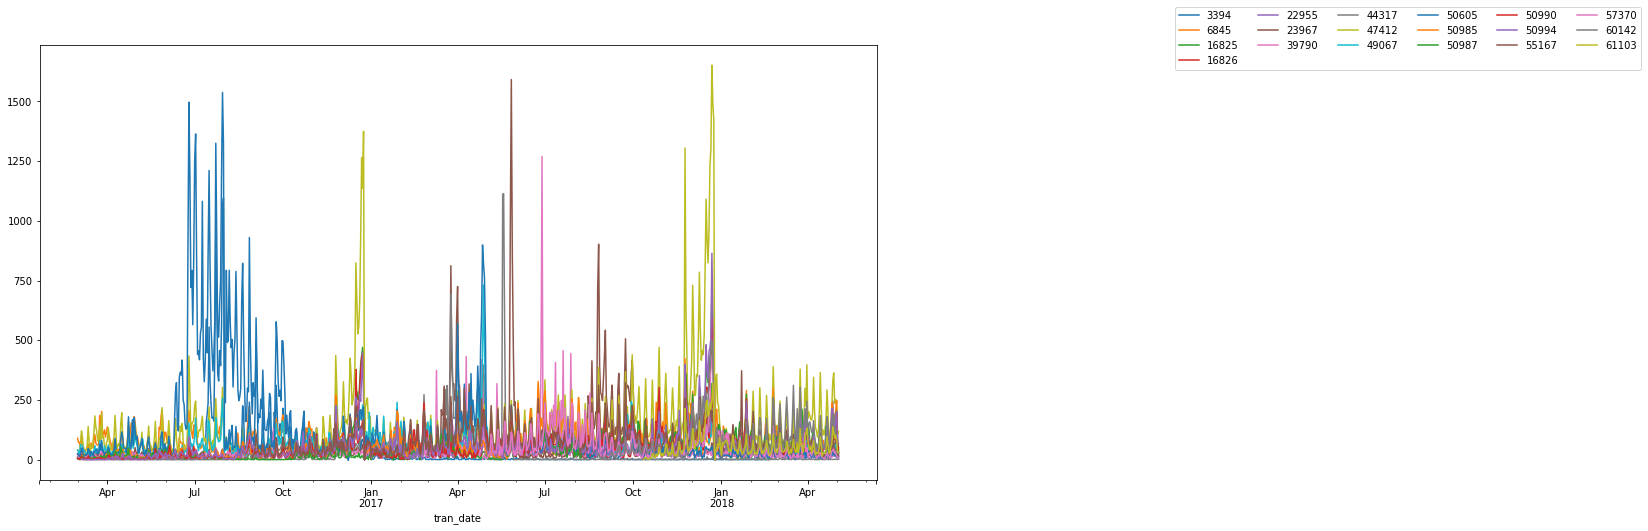

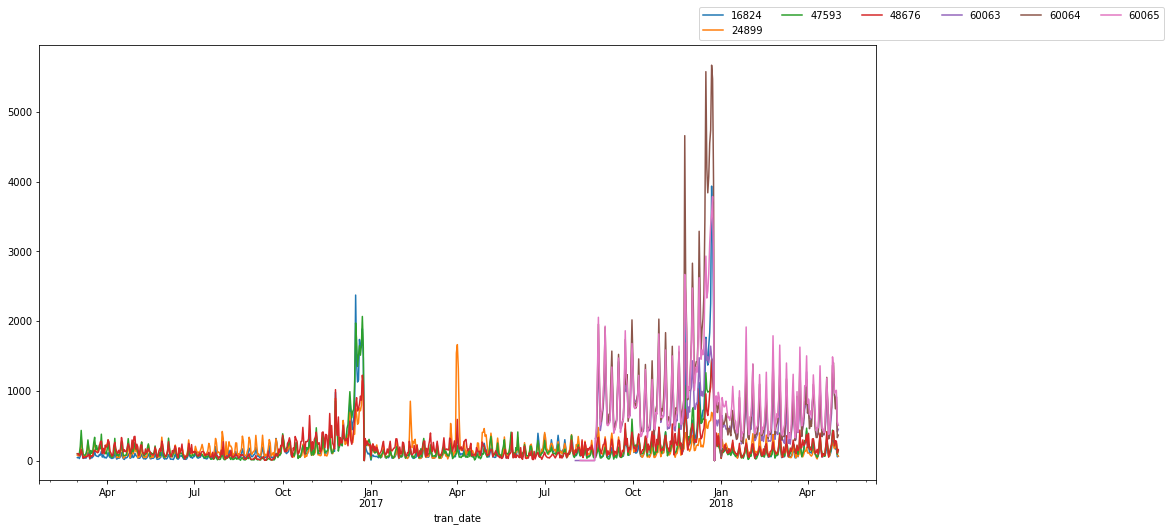

In [62]:
analyze_som.plot_all_timeseries(df_dict)

Have a look at the mean time series for each of the clusters

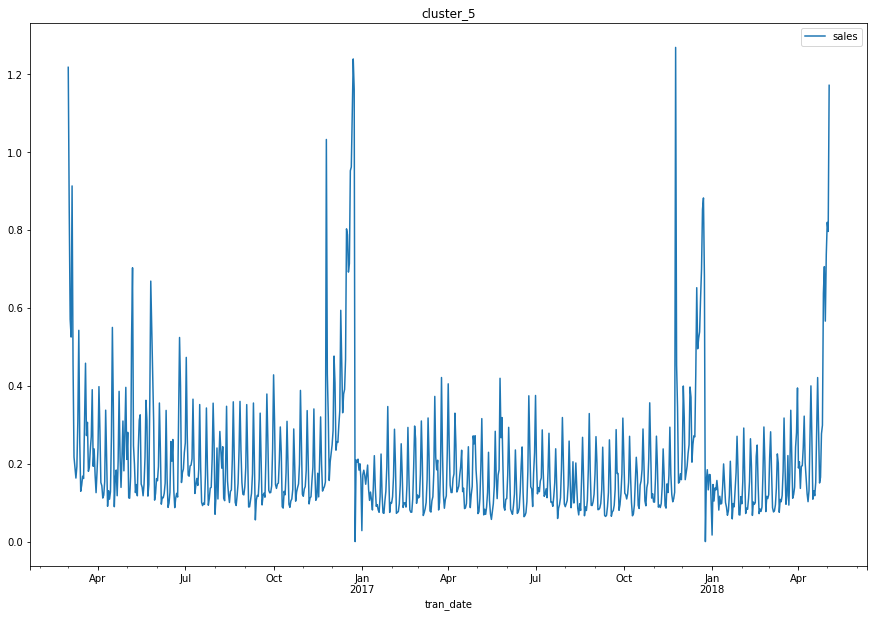

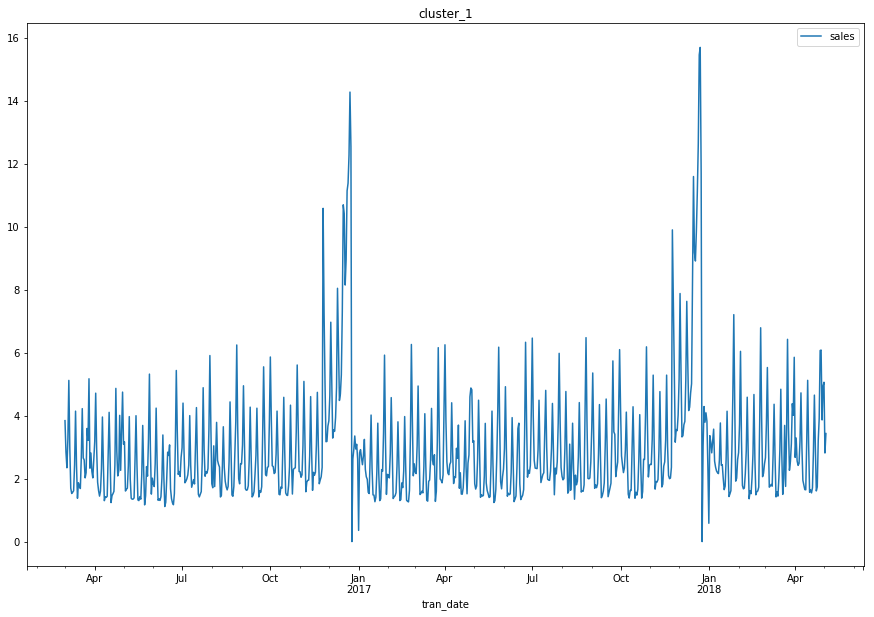

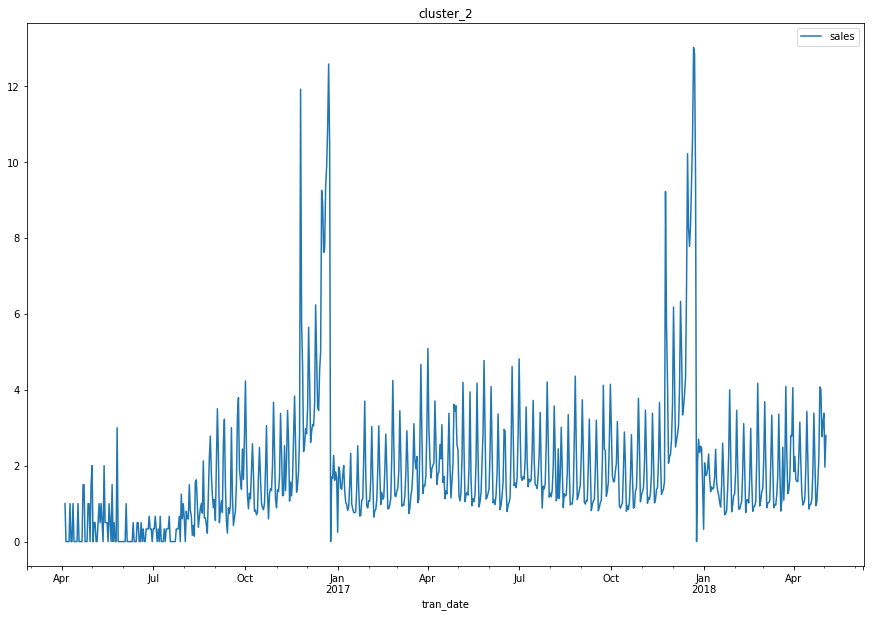

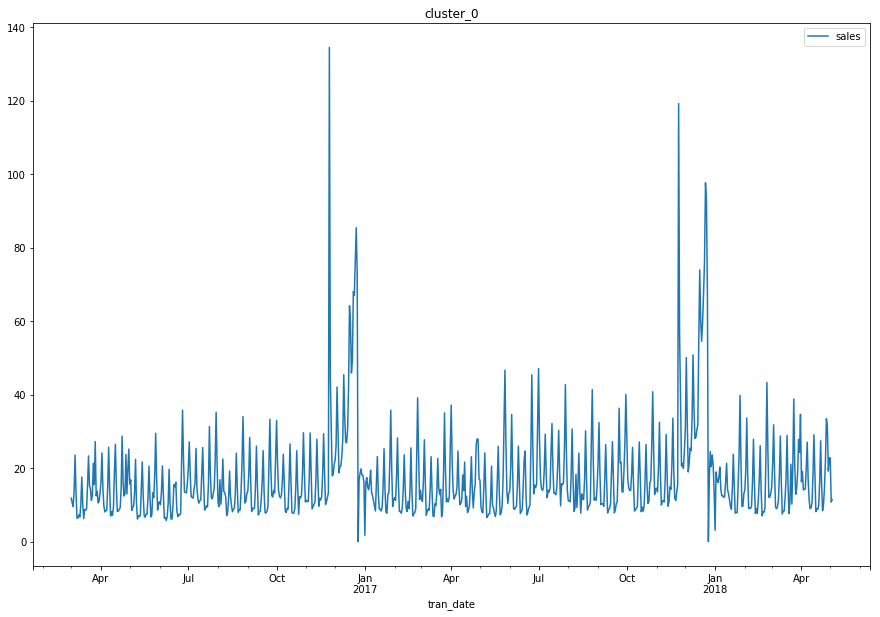

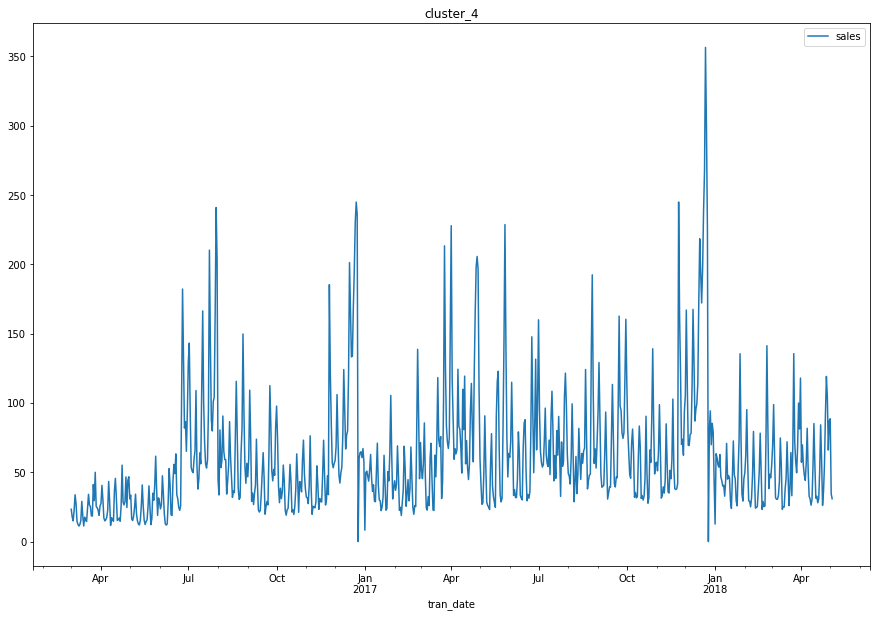

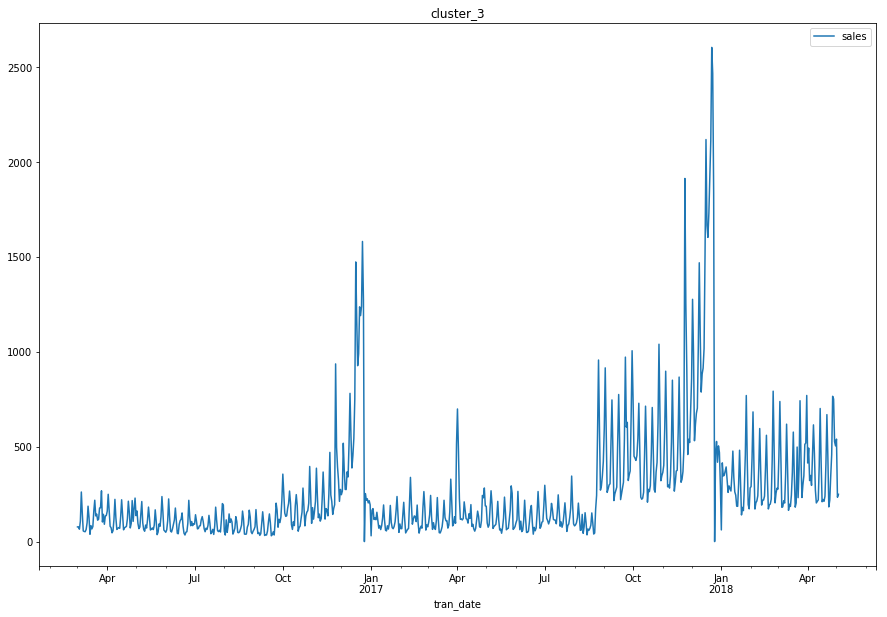

In [15]:
analyze_som.plot_mean_timeseries(df_dict)

Have a look at the median time series for each of the clusters

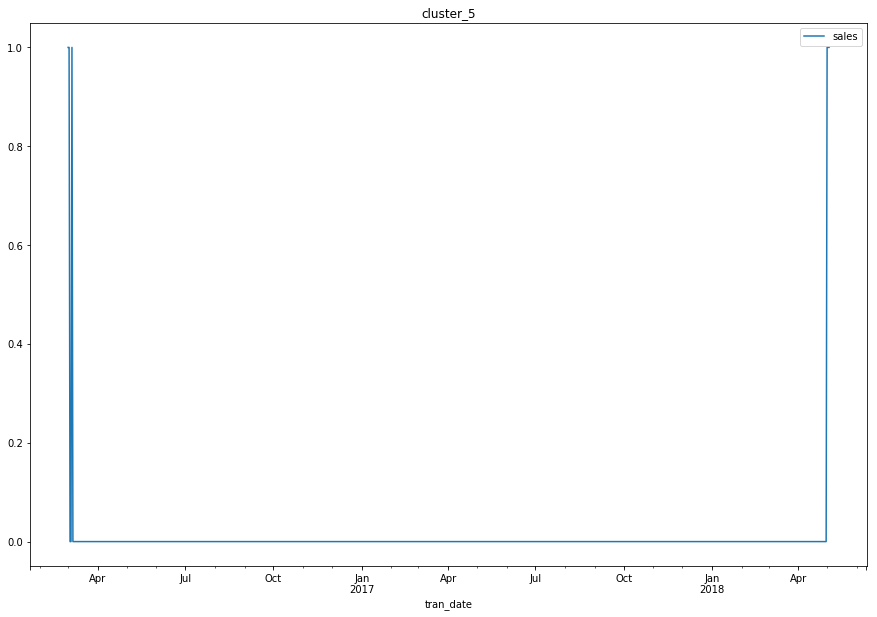

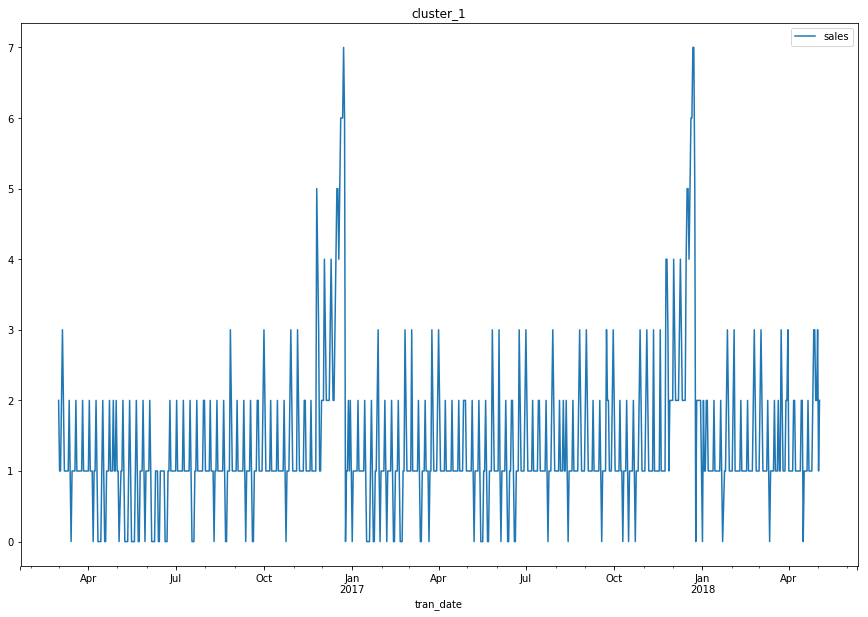

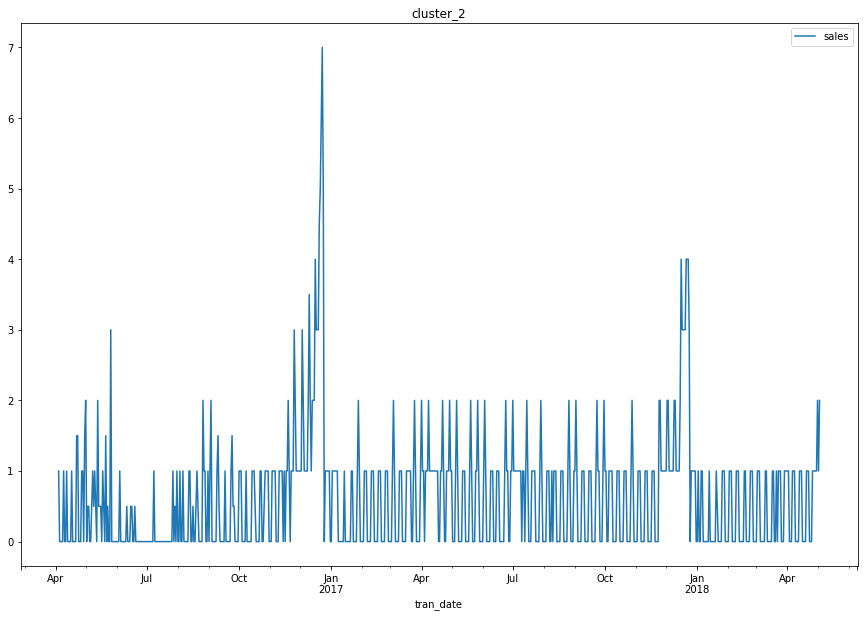

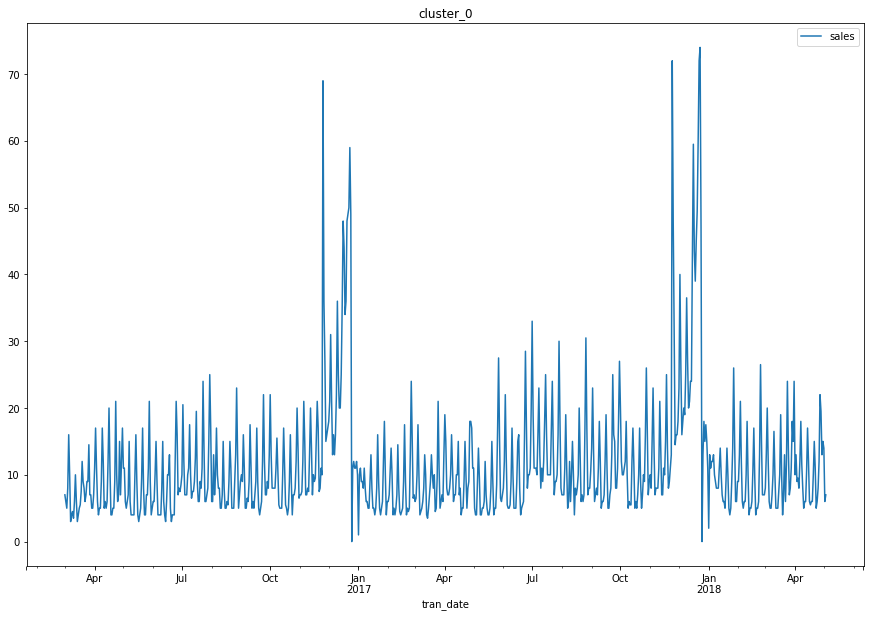

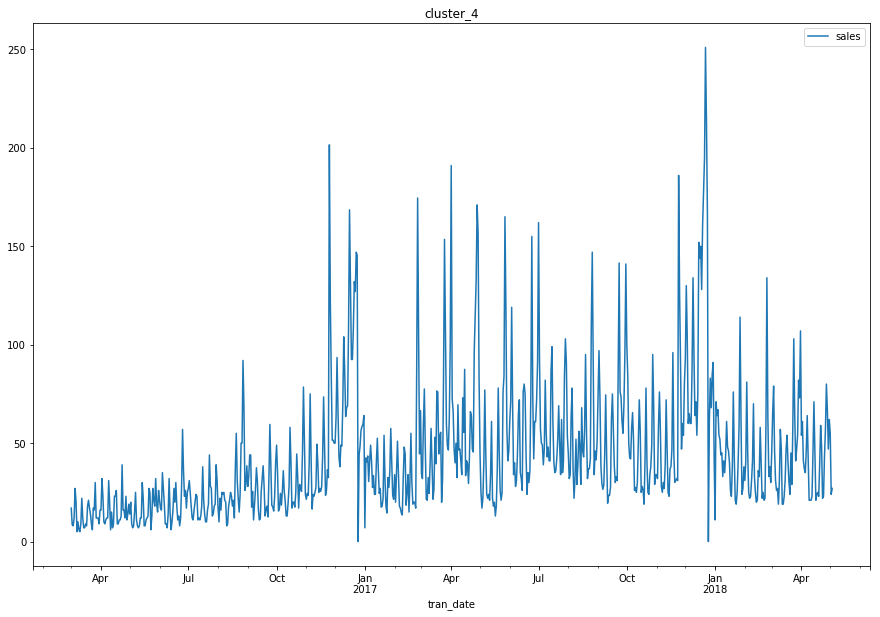

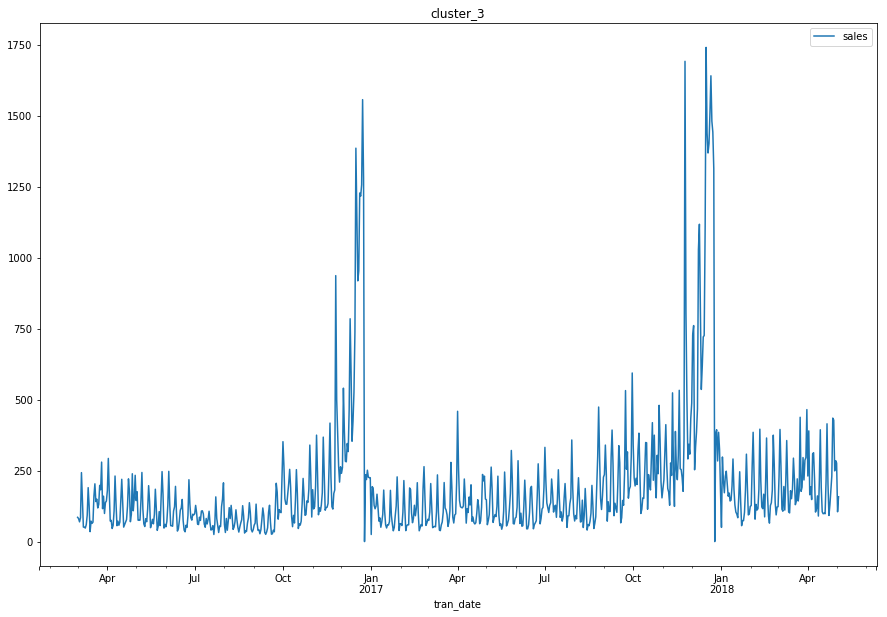

In [16]:
analyze_som.plot_median_timeseries(df_dict)

Have a look at the smoothed mean for each of the clusters

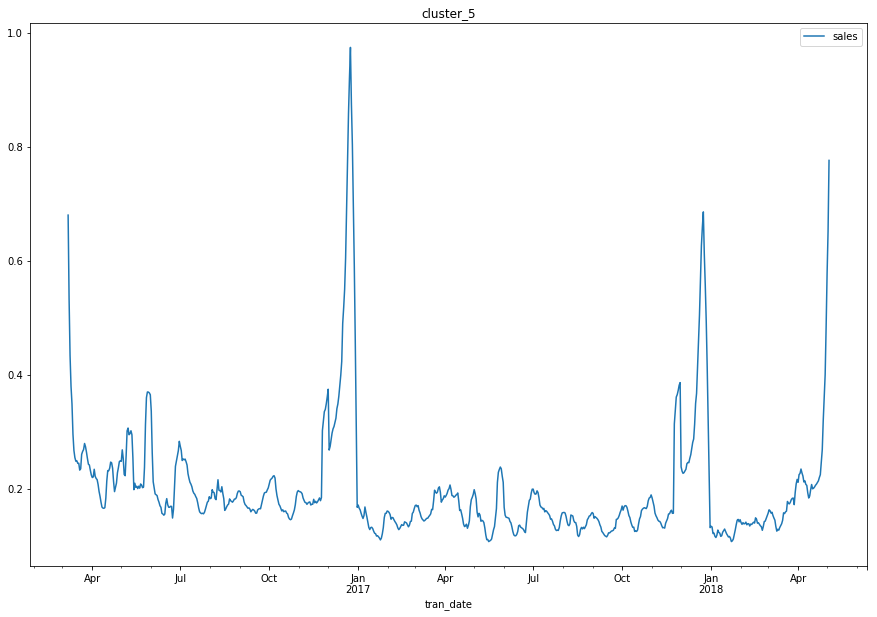

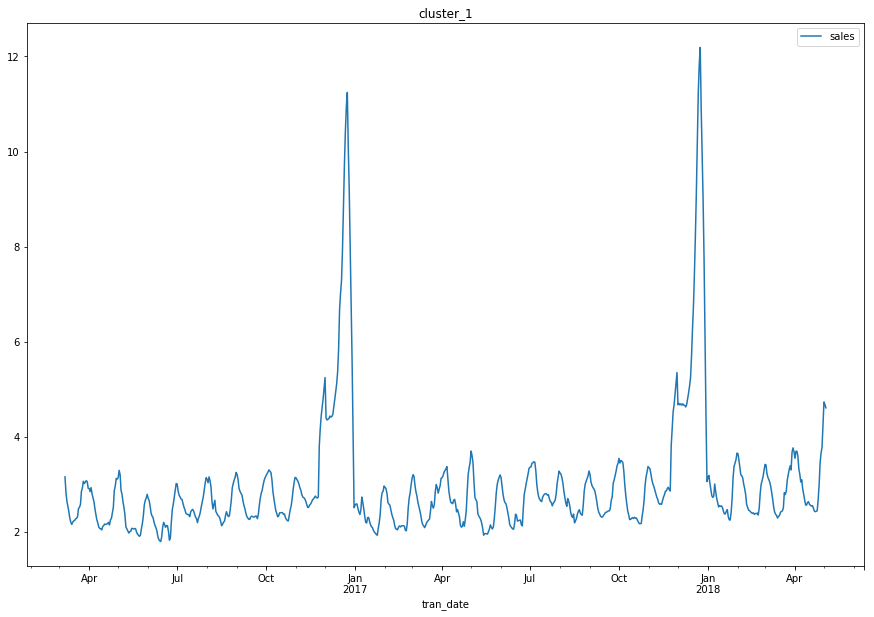

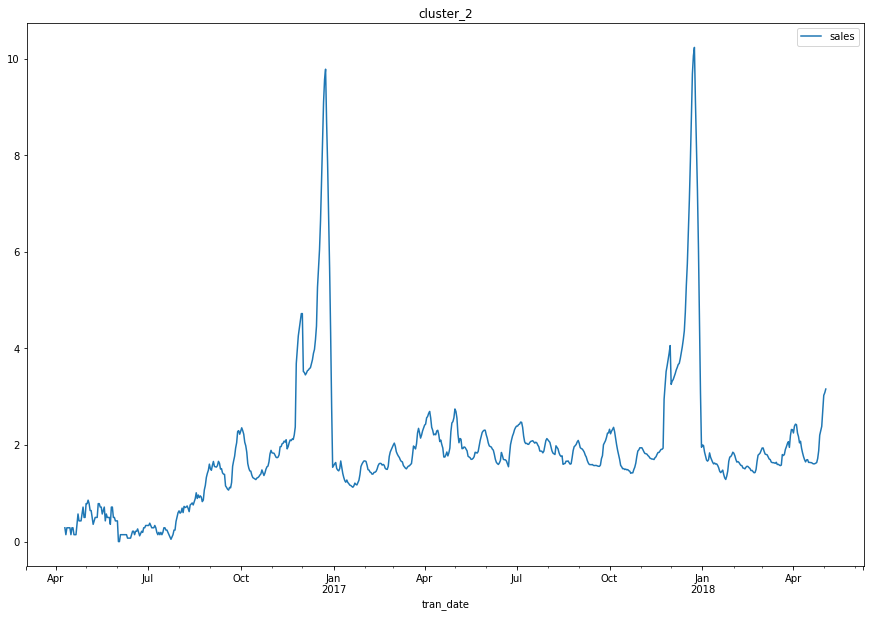

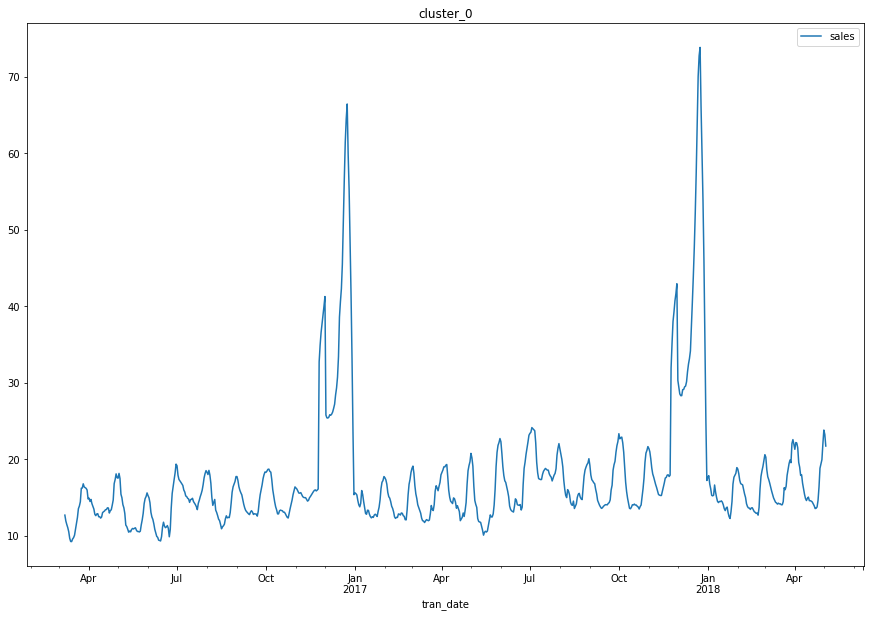

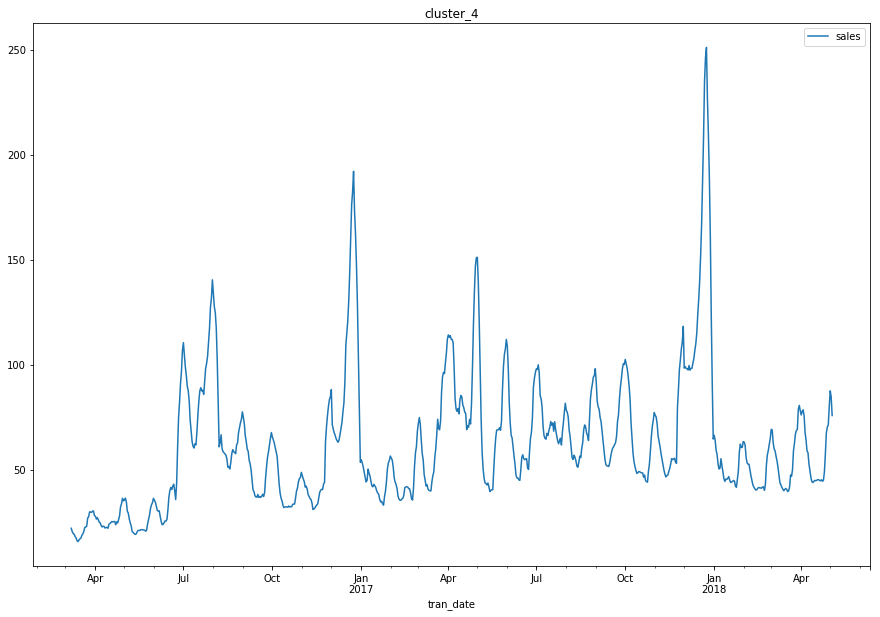

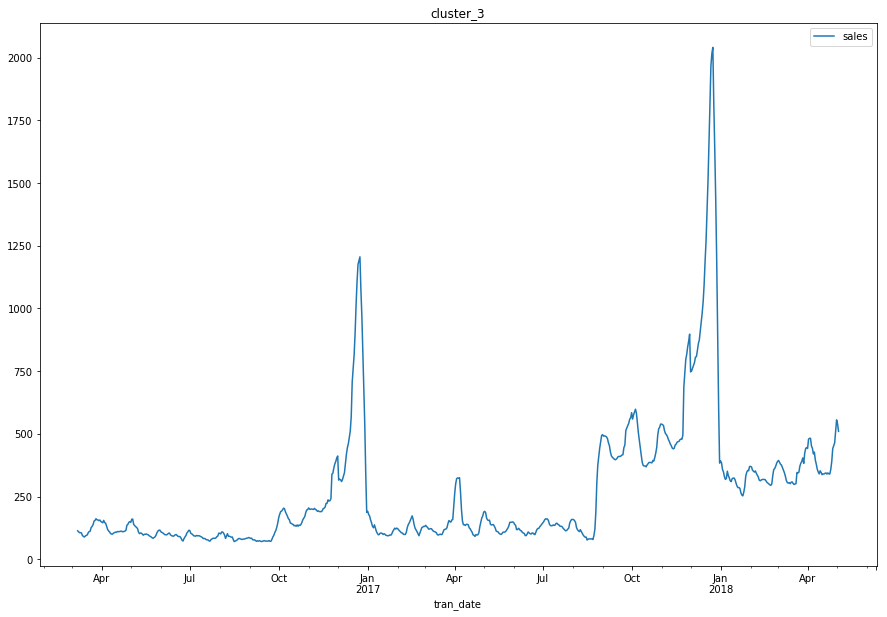

In [17]:
analyze_som.plot_rolling_mean_timeseries(df_dict, period=7)

Have a look at the amount of time series which start within the specified period or which started priod to the start of the period

cluster_5, there are 2027 skus and 249940 sales.


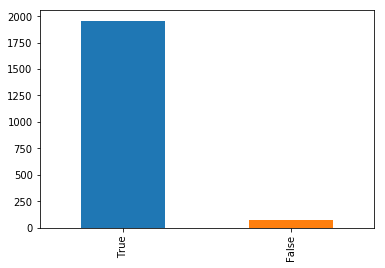

cluster_1, there are 2002 skus and 4405364 sales.


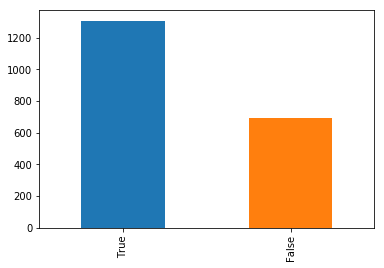

cluster_2, there are 1202 skus and 846997 sales.


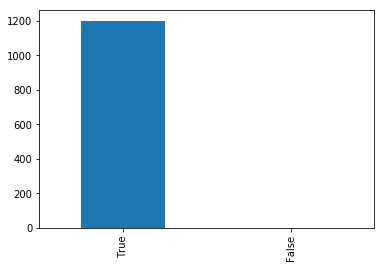

cluster_0, there are 194 skus and 2292384 sales.


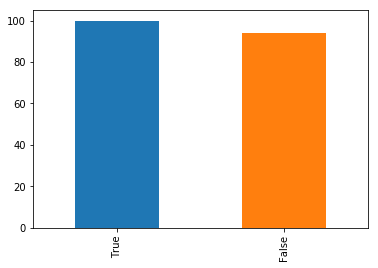

cluster_4, there are 19 skus and 833348 sales.


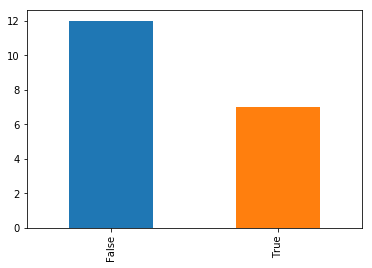

cluster_3, there are 7 skus and 1231108 sales.


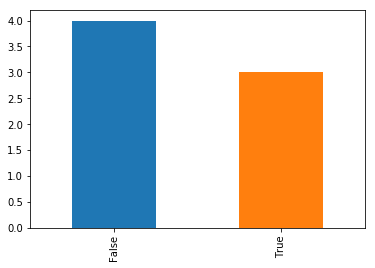

In [18]:
for i, j in df_dict.items():
    print('{}, there are {} skus and {} sales.'.format(i, len(j['sku_key'].unique()), sum(j['sales'])))
    pivot_t = pd.pivot_table(j, index='sku_key', columns='tran_date', values='sales')
    pivot_t['nan'] = pivot_t.iloc[:,0].apply(np.isnan)
    pivot_t['nan'].value_counts().plot(kind='bar')
    plt.show()

Have a look at the distribution of the continuous variables for each cluster

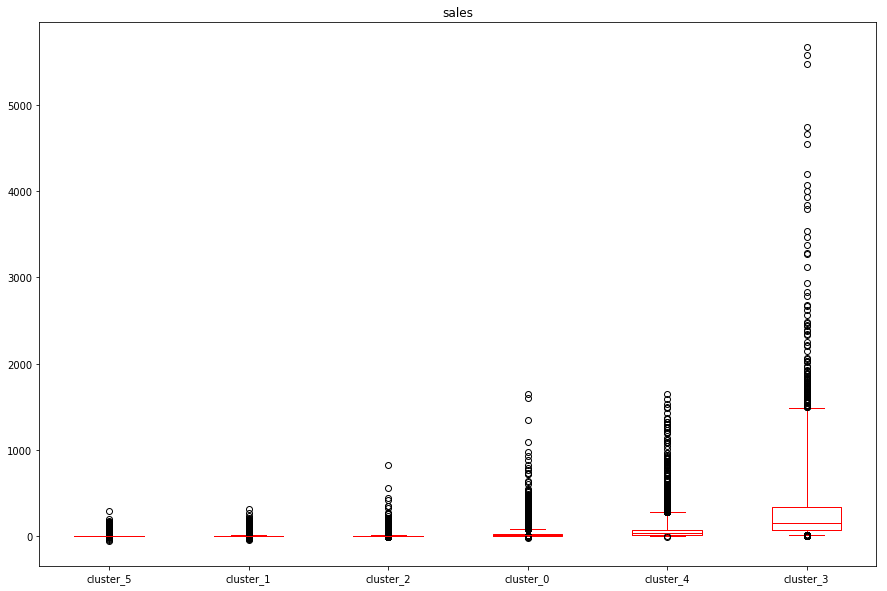

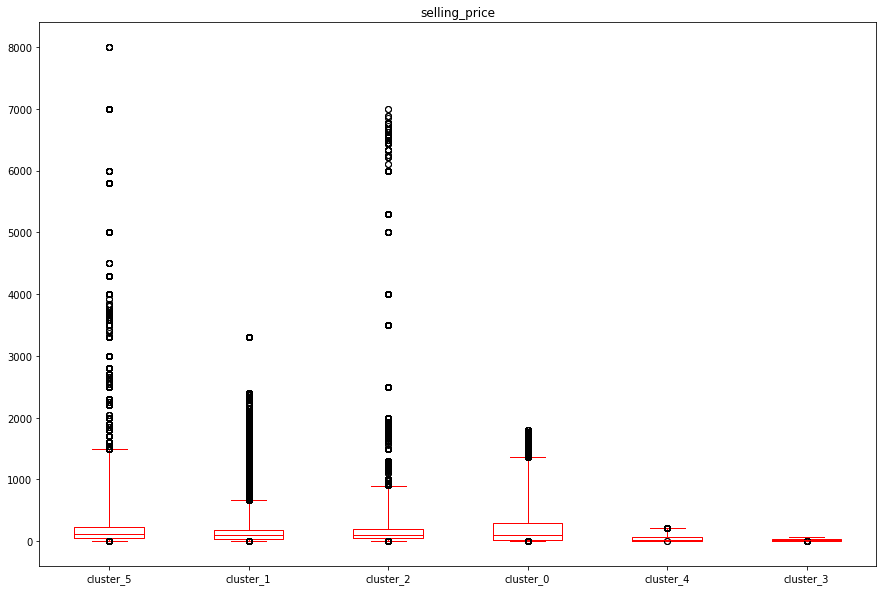

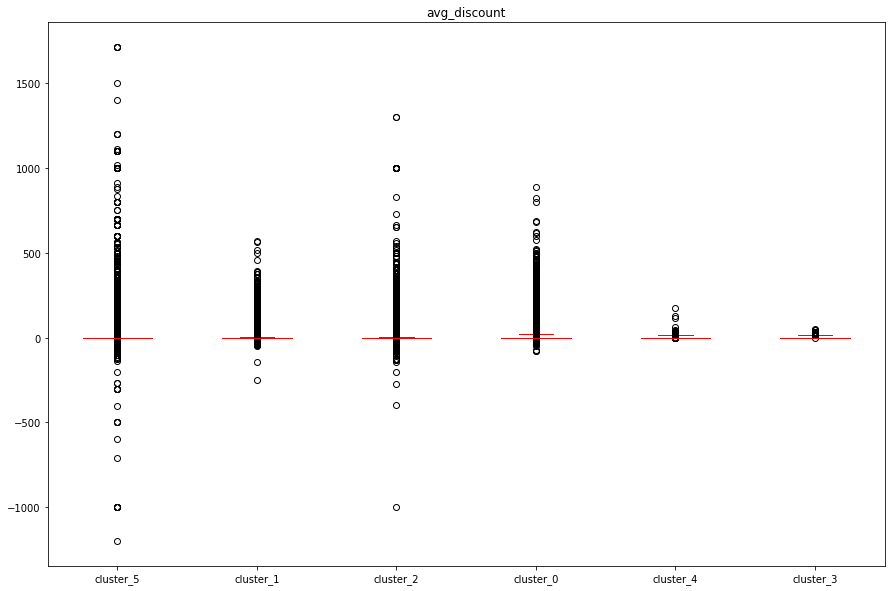

In [20]:
analyze_som.plot_cluster_continuous_box(df_dict, run_cont, True)
#OPTIONAL BELOW
#analyze_som.plot_cluster_continuous(df_dict, run_cont, colors, True)
#analyze_som.plot_cluster_continuous_violin(df_dict, run_cont, True)

Categorical variables per cluster



 sku_department


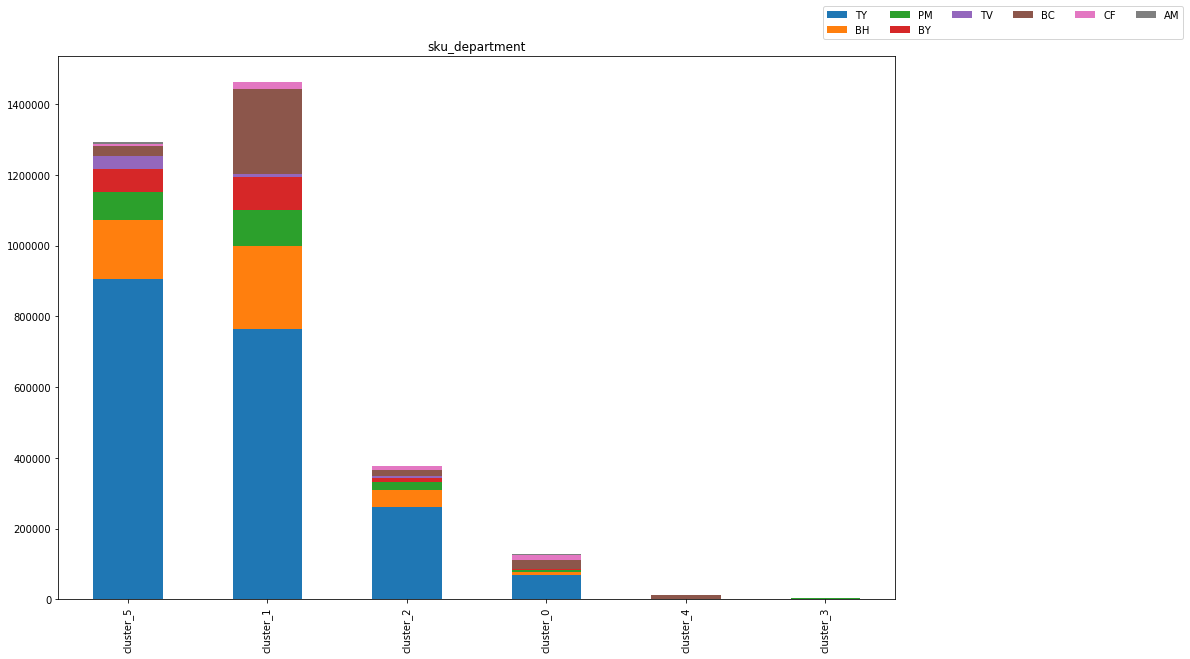



 sku_subdepartment


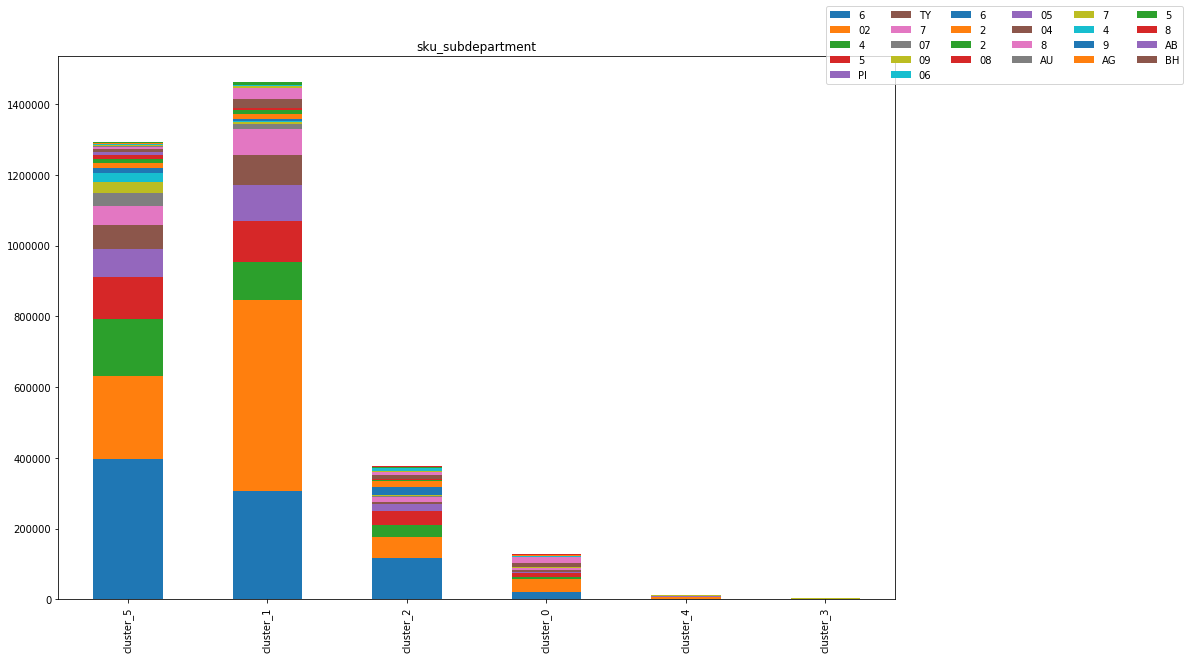



 sku_category


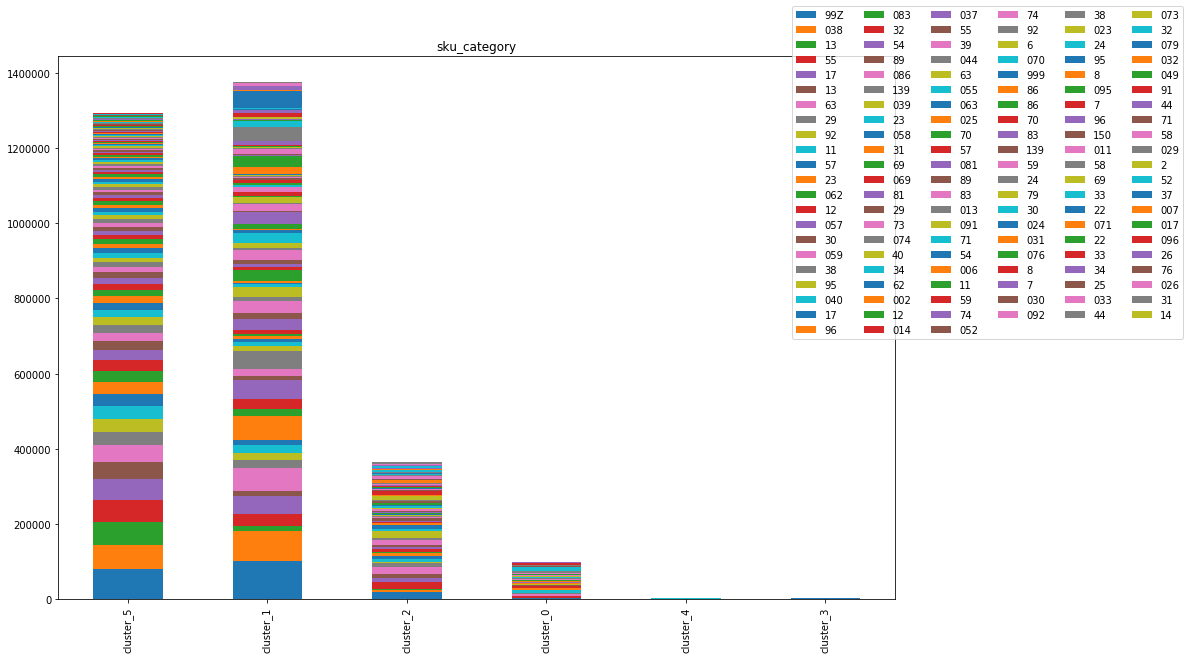



 sku_subcategory


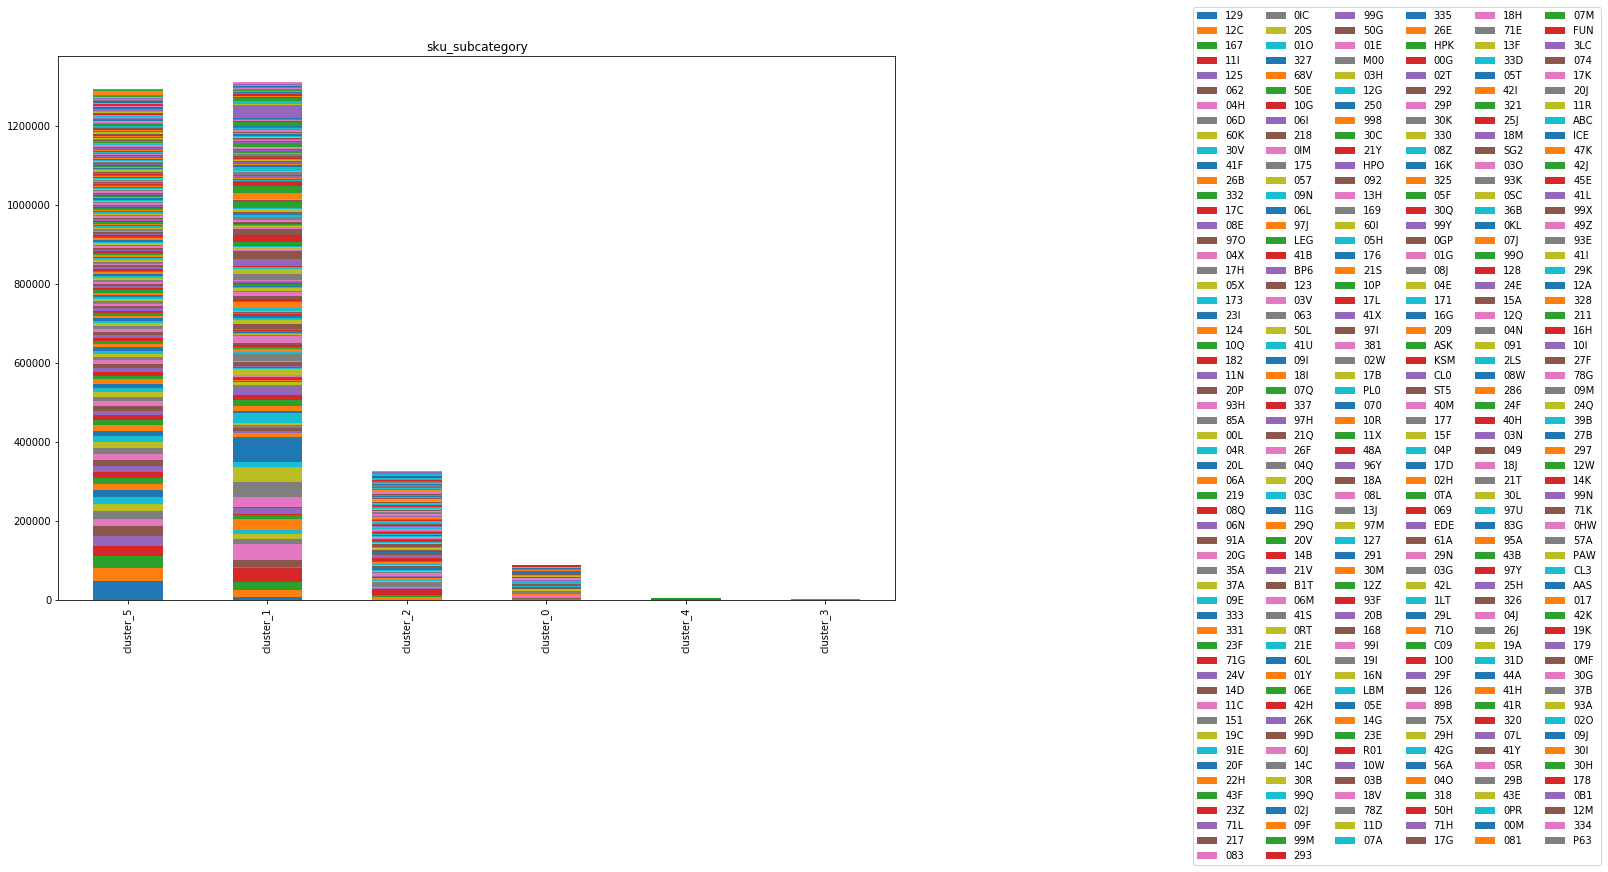

In [21]:
analyze_som.plot_cluster_categorical(df_dict, run_cats, True)

Some messy inferential stats:

In [22]:
analyze_som.test_continuous_feat(df_dict, run_cont)


 
 sales
                sum_sq         df              F  PR(>F)
cluster   4.601521e+08        5.0  256994.180135     0.0
Residual  1.113149e+09  3108459.0            NaN     NaN 

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
  group1    group2   meandiff   lower     upper   reject
--------------------------------------------------------
cluster_0 cluster_1  -14.9012  -15.0595  -14.7429  True 
cluster_0 cluster_2  -15.7356  -15.9104  -15.5608  True 
cluster_0 cluster_3  291.7256  290.857   292.5942  True 
cluster_0 cluster_4  44.4828    43.992   44.9735   True 
cluster_0 cluster_5  -17.7939  -17.9522  -17.6356  True 
cluster_1 cluster_2  -0.8344   -0.9343   -0.7345   True 
cluster_1 cluster_3  306.6268  305.7702  307.4834  True 
cluster_1 cluster_4   59.384   58.9147   59.8533   True 
cluster_1 cluster_5  -2.8927   -2.9598   -2.8257   True 
cluster_2 cluster_3  307.4612  306.6013  308.321   True 
cluster_2 cluster_4  60.2183   59.7432   60.6934   True 
cluster_2 cluster_5

Now moving to cumulative sales per cluster

In [24]:
som_sales_df = sales_df.merge(som_clus, on='sku_key')
som_sales_df.head()

sku_key  sales         0         1  sales_log  cluster
0       28    122  2.899102 -1.514008   2.086360        5
1       34    794  4.936185  5.634473   2.899821        1
2      100   9186  7.631331  7.253427   3.963126        1
3      101     27  3.060060 -2.803384   1.431364        5
4      102    153  3.219488  1.112294   2.184691        5

cluster 5
2027


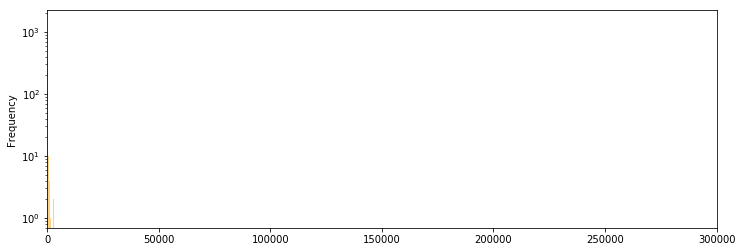

cluster 1
2002


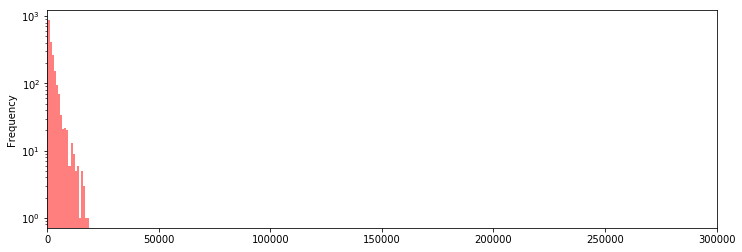

cluster 2
1202


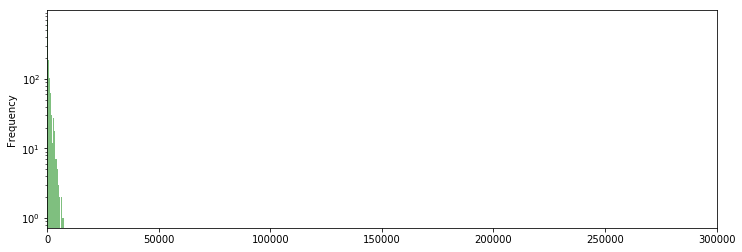

cluster 0
194


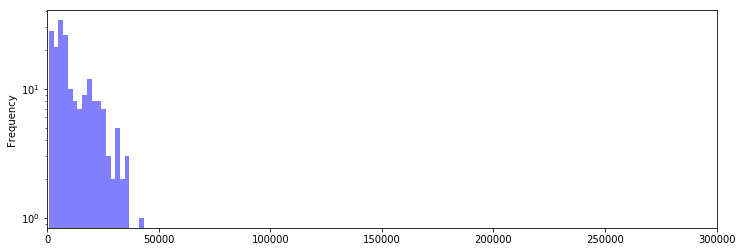

cluster 4
19


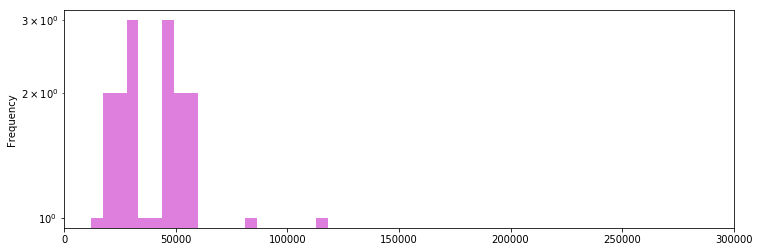

cluster 3
7


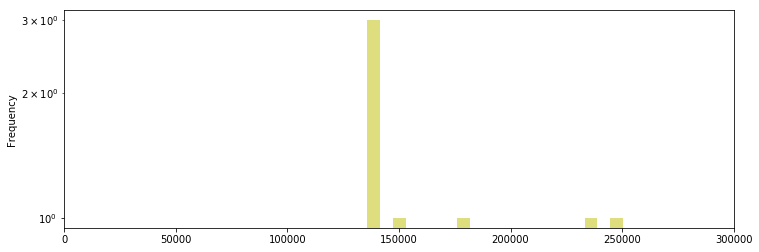

In [29]:
for i in som_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(som_sales_df[som_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    som_sales_df[som_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 300000)
    plt.show()

In [30]:
for a, i in enumerate(som_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


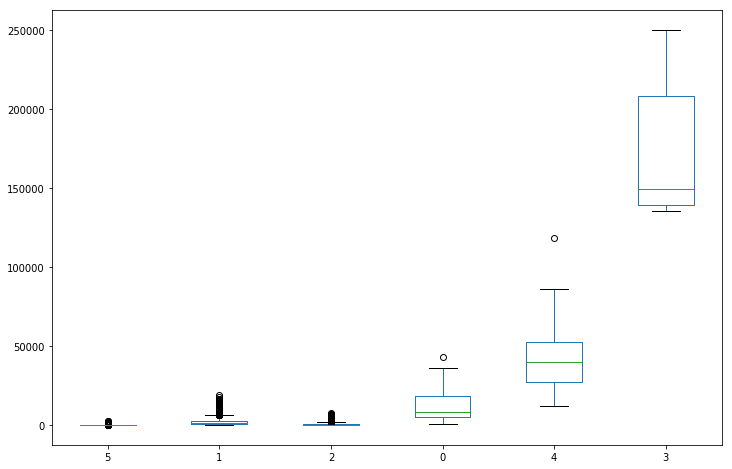

In [32]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)


In [33]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

cluster  value
0        5  122.0
3        5   27.0
4        5  153.0
5        5   35.0
7        5   89.0

In [34]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq      df           F        PR(>F)
cluster   7.895201e+09     1.0  134.284511  1.081467e-30
Residual  3.203716e+11  5449.0         NaN           NaN


In [35]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
group1 group2   meandiff      lower        upper     reject
-----------------------------------------------------------
  0      1     -9615.9309  -10301.0266   -8930.8351   True 
  0      2     -11111.756  -11816.7048  -10406.8071   True 
  0      3    164056.1591  160550.9322  167561.3859   True 
  0      4     32044.0087   29853.8271   34234.1902   True 
  0      5     -11693.107  -12377.8294  -11008.3846   True 
  1      2     -1495.8251   -1828.2779   -1163.3723   True 
  1      3    173672.0899  170222.4251  177121.7547   True 
  1      4     41659.9395   39559.8283   43760.0508   True 
  1      5     -2077.1761   -2364.2593   -1790.093    True 
  2      3     175167.915  171714.2526  178621.5774   True 
  2      4     43155.7646   41049.0933   45262.436    True 
  2      5      -581.351    -913.0338    -249.6683    True 
  3      4    -132012.1504 -136040.5156 -127983.7852  True 
  3      5    -175749.2661 -179198.8567 